In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import secondary_fyncions as sf
import scipy as sc
import warnings

from scipy.spatial.distance import cdist
from sklearn.cluster import DBSCAN
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.base import BaseEstimator
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

warnings.simplefilter('ignore')

In [2]:
data = sc.io.loadmat('cardio.mat')

In [3]:
X = pd.DataFrame(data['X'])
y = pd.DataFrame(data['y'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f25bdd579e8>,
      dtype=object)

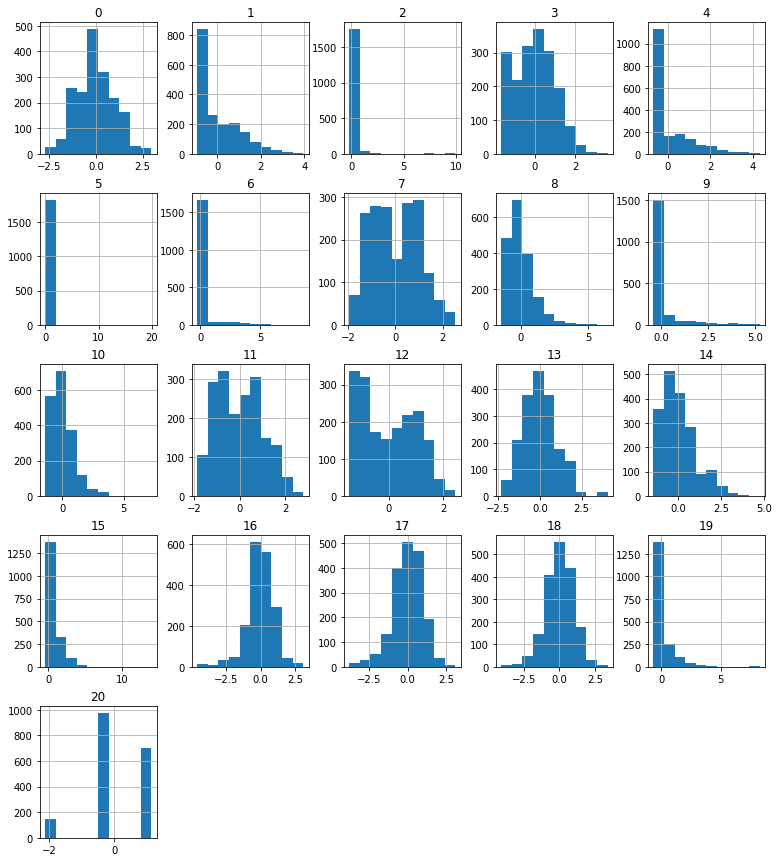

In [4]:
X.hist(figsize=(13, 15))

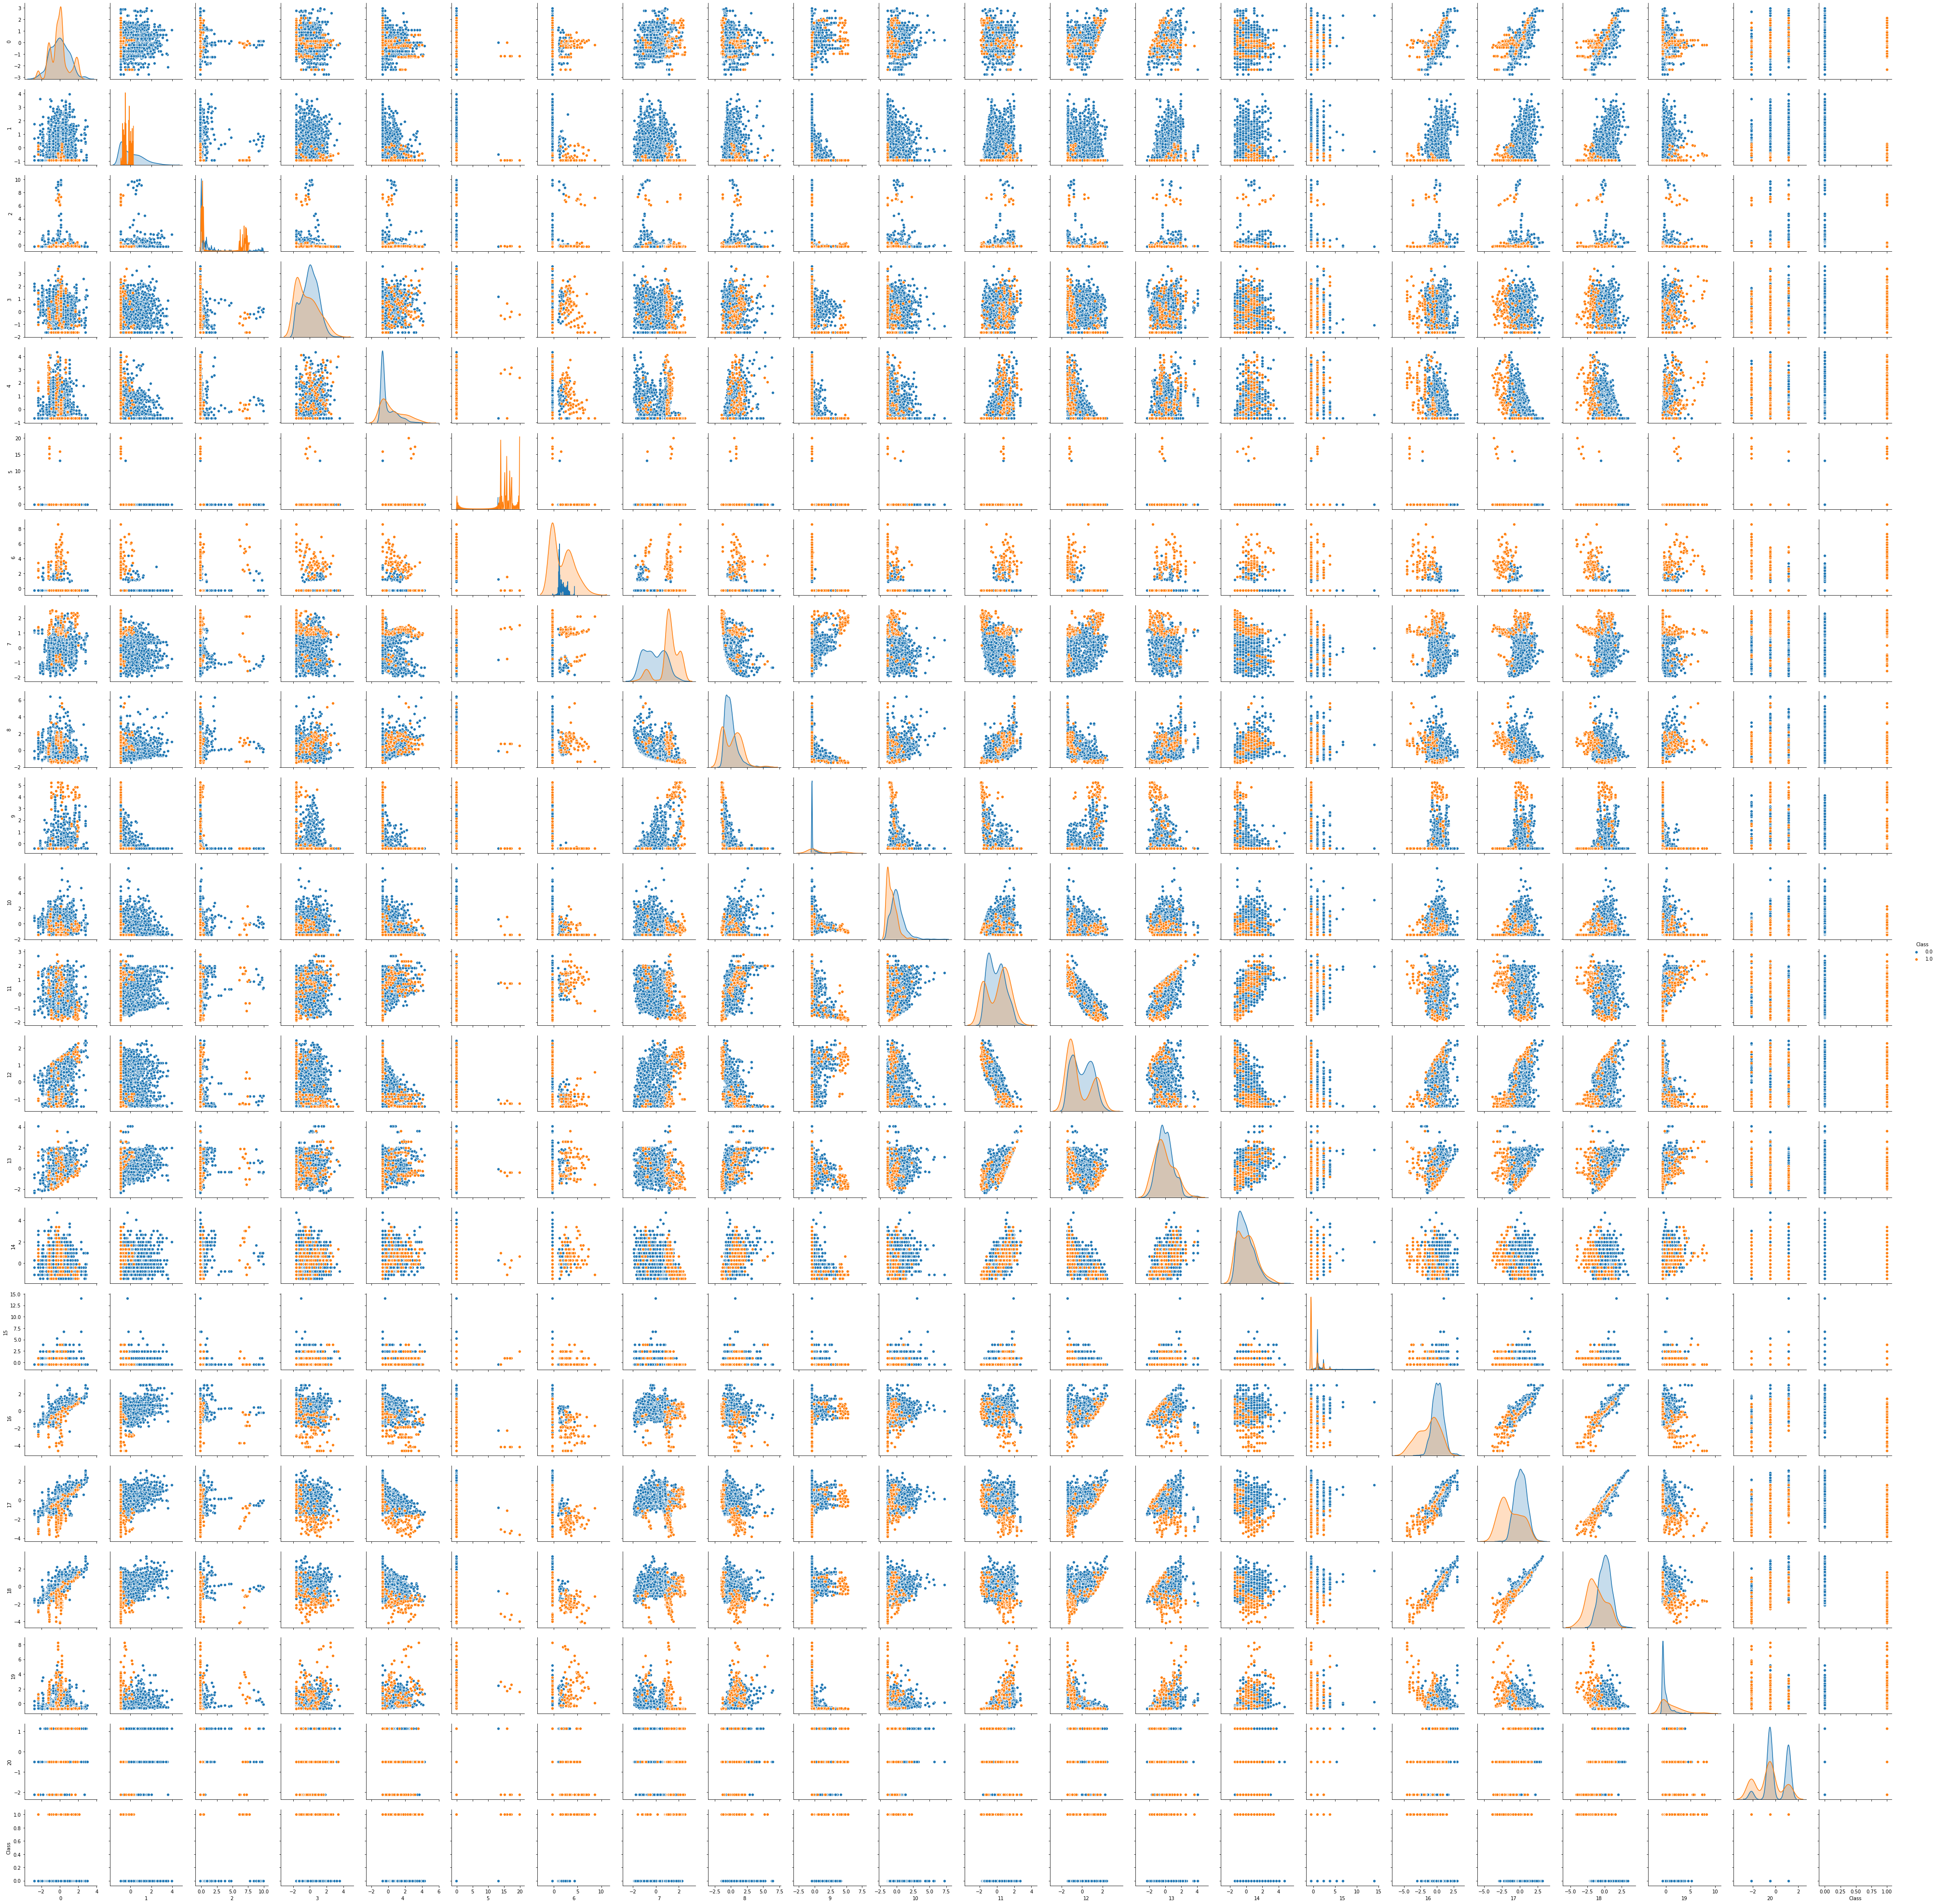

In [5]:
sns.pairplot(pd.concat([X, y.rename(columns={0:'Class'})], axis=1), hue='Class')

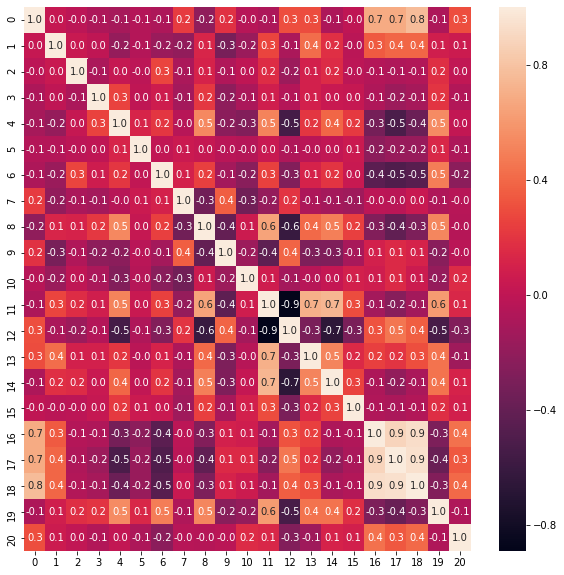

In [6]:
plt.figure(figsize=(10, 10))
sns.heatmap(X.corr(), annot=True, fmt='.1f')

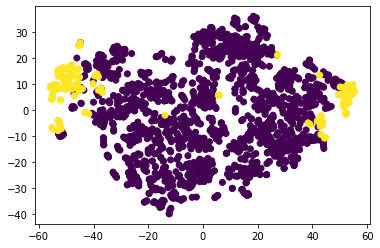

In [7]:
tsne = TSNE(perplexity=50).fit_transform(X)
plt.scatter(tsne[:, 0], tsne[:, 1], c=y[0])

# Шкалирование

In [8]:
scaled = StandardScaler()
X_scaled = scaled.fit_transform(X)

# Поиск аномалий
## Алгоритмы умеющие обучаться на грязных данных
### DBSCAN, подбор параметра eps

In [9]:
outlier_percentage = 100.
eps = 1.
while outlier_percentage > 9.7:
    model = DBSCAN(eps=eps).fit(X_scaled)
    outlier_percentage = 100*list(model.labels_).count(-1)/X_scaled.shape[0]
    eps += 0.005

db = DBSCAN(eps=eps).fit(X_scaled)
labels = db.labels_
dbscan_labels = np.where(db.labels_ == -1, 1, 0)
n_clusters_ = len(set(labels)) - (set(labels) >= set([-1])) * 1
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: {}'.format(n_clusters_))
print('Estimated percentage of noise points: {:.2f}%'.format(100*n_noise_/X_scaled.shape[0]))
print(f'EPS = {eps:.3f}')


Estimated number of clusters: 8
Estimated percentage of noise points: 9.67%
EPS = 2.630


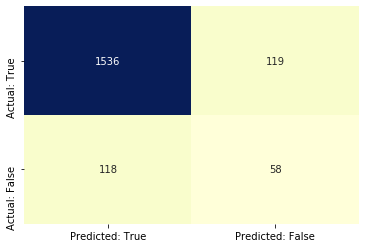

In [10]:
sf.plot_confusion(y[0], np.where(db.labels_ == -1, 1, 0))

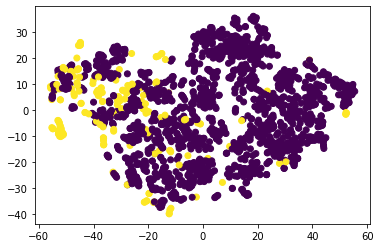

In [11]:
plt.scatter(tsne[:, 0], tsne[:, 1], c=dbscan_labels)

### IsolationForest, подбор параметра contamination

In [12]:
outlier_percentage = 0.
c = 0.01
while outlier_percentage < 9.6:
    model = IsolationForest(n_estimators=100, contamination=c, max_features=0.4, bootstrap=True).fit(X_scaled)
    preds = model.predict(X_scaled)
    preds = np.where(preds == -1, 1, 0)
    n_noise_ = preds.sum()
    outlier_percentage = 100*n_noise_/X_scaled.shape[0]
    print(f"c={c:.2f}, outlier_percentage={outlier_percentage:.2f}")
    c += 0.01
else:
    c -= 0.01
    print(f"Best contamination={c:.2f}")
    


c=0.01, outlier_percentage=1.04
c=0.02, outlier_percentage=2.02
c=0.03, outlier_percentage=3.00
c=0.04, outlier_percentage=4.04
c=0.05, outlier_percentage=5.02
c=0.06, outlier_percentage=6.01
c=0.07, outlier_percentage=7.05
c=0.08, outlier_percentage=8.03
c=0.09, outlier_percentage=9.01
c=0.10, outlier_percentage=9.99
Best contamination=0.10


In [13]:
model = IsolationForest(n_estimators=100, contamination=c, max_features=0.4, bootstrap=True)

model.fit(X_scaled)

preds = model.predict(X_scaled)
preds = np.where(preds == -1, 1, 0)
isolation_labels = preds
n_noise_ = preds.sum()
print('Estimated percentage of noise points: {:.2f}%'.format(100*n_noise_/X_scaled.shape[0]))

Estimated percentage of noise points: 9.99%


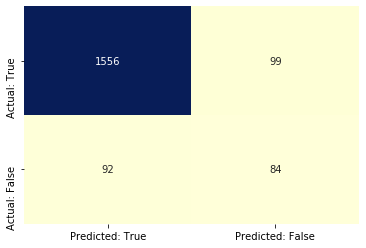

In [14]:
sf.plot_confusion(y[0], preds)

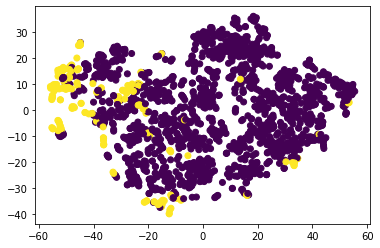

In [15]:
plt.scatter(tsne[:, 0], tsne[:, 1], c=isolation_labels)

## Алгоритмы умеющие обучаться только на чистый данных
### OneClassSVM

In [16]:
# сделаем чистый датасет
data_all = pd.concat([pd.DataFrame(X_scaled), y.rename(columns={0: 'Class'})], axis=1)
data_clean = data_all[data_all['Class'] == 0].drop(columns=['Class'])

Estimated percentage of noise points: 10.81%


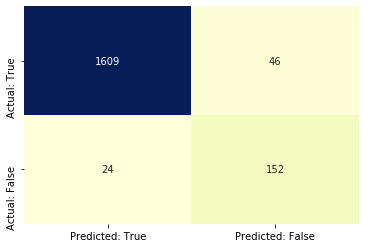

In [17]:
model = OneClassSVM(nu=0.001)
model.fit(data_clean)
preds = model.predict(data_all.drop(columns=['Class']))

preds = np.where(preds == -1, 1, 0)
oneclasssvm_labels = preds
n_noise_ = preds.sum()
print('Estimated percentage of noise points: {:.2f}%'.format(100*n_noise_/X_scaled.shape[0]))
sf.plot_confusion(y[0], preds)

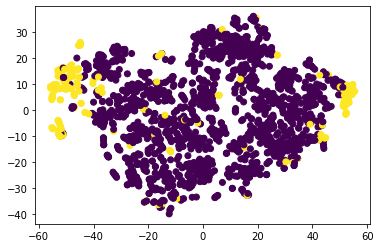

In [18]:
plt.scatter(tsne[:, 0], tsne[:, 1], c=oneclasssvm_labels)

## DistanceOutliers

In [19]:
class DistanceOutliers(BaseEstimator):
    """
    Distance based outlier detector model
    
    Fit method calculates centroid of training samples and
    using `metric` get distances from centroid to train samples.
    Having distances - we calculate `threshold` based on `percentile`.
    
    Predict method uses `threshold` and `metric` to determine, whether
    distance to sample from centroid is too large -> outlier.
    
    -----------
    Parameters:
    
    - metric: string, default - euclidean
        metric to use for distance calculation (see scipy.spatial.distance.cdist)
        
    - percentile: float in range [0, 100]
        hyperparameter which sets the threshold for anomalies
    """
    def __init__(self, metric='euclidean', percentile=90):
        self.metric = metric
        self.percentile = percentile
        
    def fit(self, X):
        self.centroid = np.mean(X, axis=0).values.reshape(-1, 1).T
        distances_train = cdist(self.centroid, X, metric=self.metric).reshape(-1)
        self.threshold = np.percentile(distances_train, self.percentile)
        
    def predict(self, X):
        distances = cdist(self.centroid, X, metric=self.metric).reshape(-1)
        predictions = (distances > self.threshold).astype(int)
        return predictions

In [20]:
euclidian_model = DistanceOutliers(metric='euclidean', percentile=95)
euclidian_model.fit(data_clean)
preds = euclidian_model.predict(data_all.drop(columns=['Class']))
distance_labels = preds
n_noise_ = preds.sum()
print('Estimated percentage of noise points: {:.2f}%'.format(100*n_noise_/X_scaled.shape[0]))

Estimated percentage of noise points: 11.91%


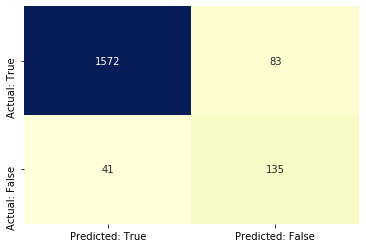

In [21]:

sf.plot_confusion(y[0], distance_labels)

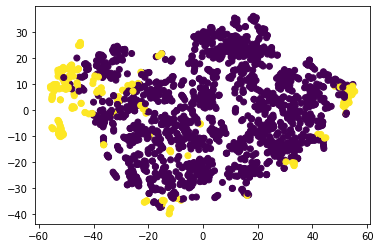

In [22]:
plt.scatter(tsne[:, 0], tsne[:, 1], c=distance_labels)

# Supervised моделя для предсказания потологии

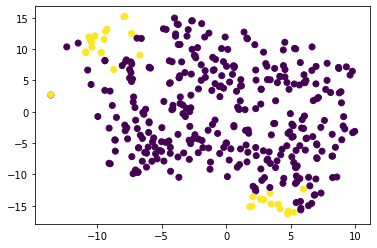

In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    data_all.drop(columns=['Class']),
    data_all['Class'],
    test_size=0.2,
    stratify=data_all['Class']
)
tsne_test = TSNE(perplexity=50).fit_transform(X_test)
plt.scatter(tsne_test[:, 0], tsne_test[:, 1], c=y_test)

## KNeighborsClassifier

In [36]:
km = KNeighborsClassifier(n_neighbors=2)
km.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

km = KMeans(n_clusters=2)

In [37]:
preds=km.predict_proba(X_test)
km_proba = preds[:,1]
km_labels=km.predict(X_test)

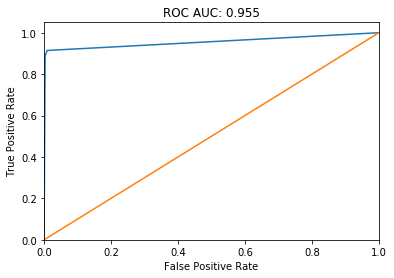

In [38]:
sf.plot_roc_curve(preds[:,1], y_test)

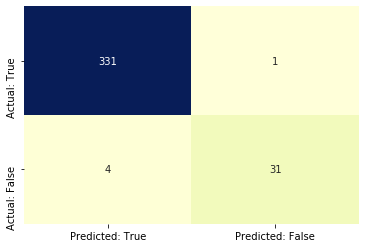

In [39]:
sf.plot_confusion(y_test, km_labels)

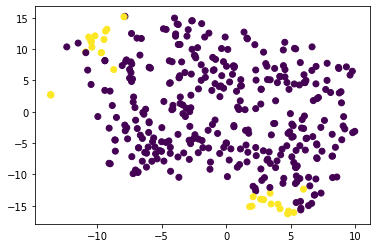

In [40]:
plt.scatter(tsne_test[:, 0], tsne_test[:, 1], c=km_labels)

## LogisticRegression

In [41]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
preds = logreg.predict_proba(X_test)
logreg_proba = preds[:,1]
logreg_labels = logreg.predict(X_test)

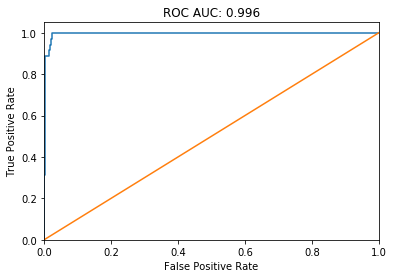

In [42]:
sf.plot_roc_curve(preds[:,1], y_test)

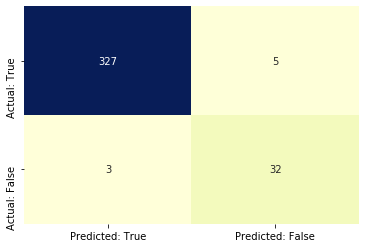

In [43]:
sf.plot_confusion(y_test, logreg.predict(X_test))

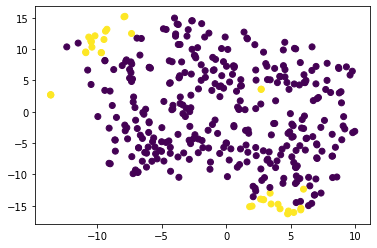

In [44]:
plt.scatter(tsne_test[:, 0], tsne_test[:, 1], c=logreg_labels)

# Выводы
## Поиск аномалий

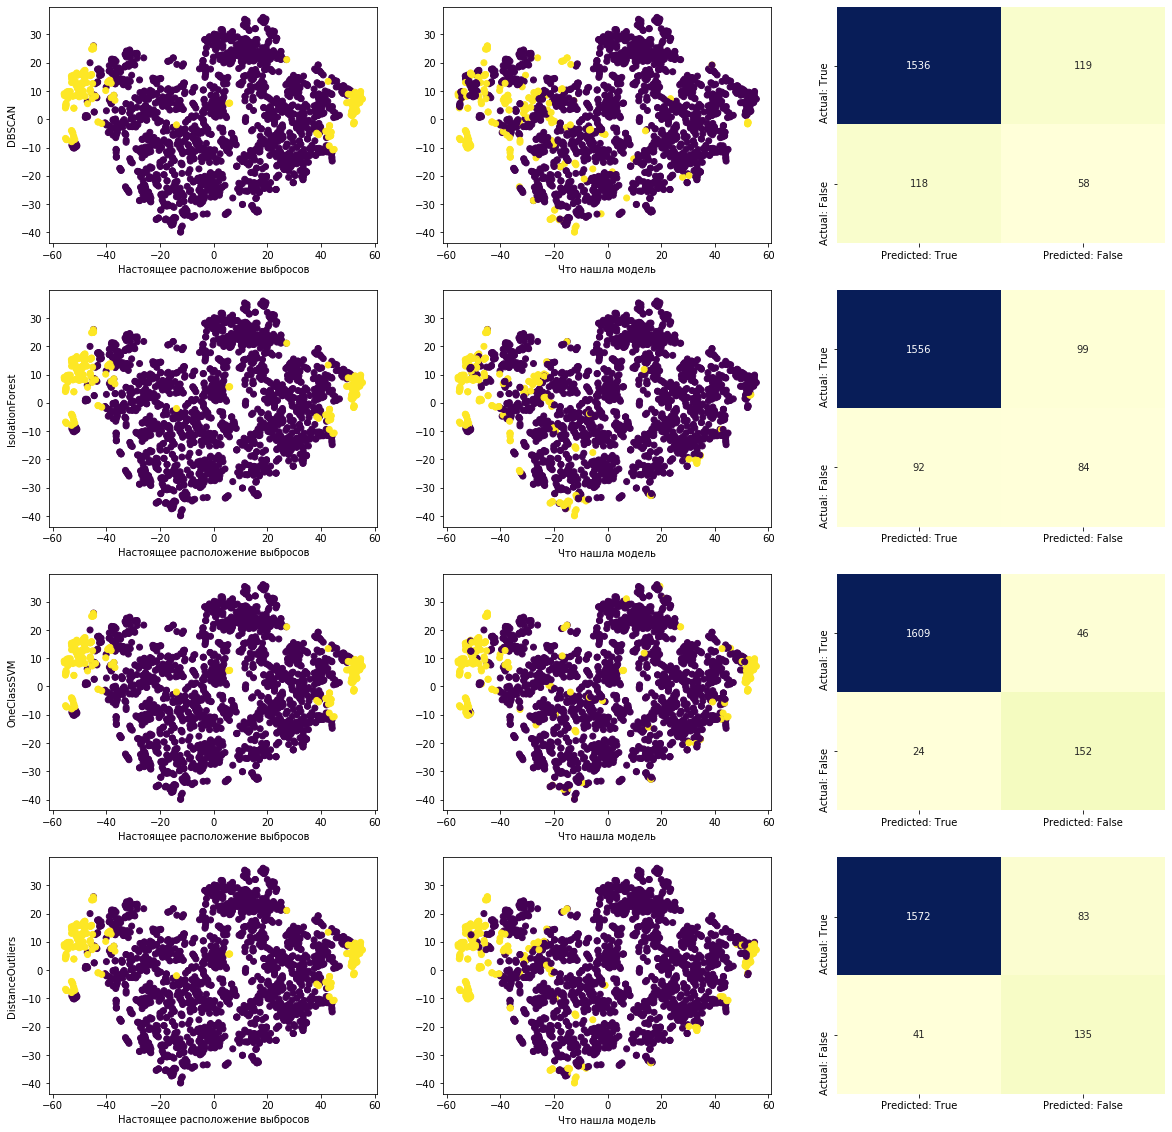

In [45]:
plt.figure(figsize=(20,20))

plt.subplot(4,3,1)
plt.scatter(tsne[:, 0], tsne[:, 1], c=y[0])
plt.xlabel('Настоящее расположение выбросов')
plt.ylabel('DBSCAN')
plt.subplot(4,3,2)
plt.scatter(tsne[:, 0], tsne[:, 1], c=dbscan_labels)
plt.xlabel('Что нашла модель')
plt.subplot(4,3,3)
sf.plot_confusion(y[0], dbscan_labels)


plt.subplot(4,3,4)
plt.scatter(tsne[:, 0], tsne[:, 1], c=y[0])
plt.xlabel('Настоящее расположение выбросов')
plt.ylabel('IsolationForest')
plt.subplot(4,3,5)
plt.scatter(tsne[:, 0], tsne[:, 1], c=isolation_labels)
plt.xlabel('Что нашла модель')
plt.subplot(4,3,6)
sf.plot_confusion(y[0], isolation_labels)

plt.subplot(4,3,7)
plt.scatter(tsne[:, 0], tsne[:, 1], c=y[0])
plt.xlabel('Настоящее расположение выбросов')
plt.ylabel('OneClassSVM')
plt.subplot(4,3,8)
plt.scatter(tsne[:, 0], tsne[:, 1], c=oneclasssvm_labels)
plt.xlabel('Что нашла модель')
plt.subplot(4,3,9)
sf.plot_confusion(y[0], oneclasssvm_labels)


plt.subplot(4,3,10)
plt.scatter(tsne[:, 0], tsne[:, 1], c=y[0])
plt.xlabel('Настоящее расположение выбросов')
plt.ylabel('DistanceOutliers')
plt.subplot(4,3,11)
plt.scatter(tsne[:, 0], tsne[:, 1], c=distance_labels)
plt.xlabel('Что нашла модель')
plt.subplot(4,3,12)
sf.plot_confusion(y[0], distance_labels)

Лучше всех с задачей поиска аномалий справилась модель OneClassSVM

## Предсказание потологий сердца

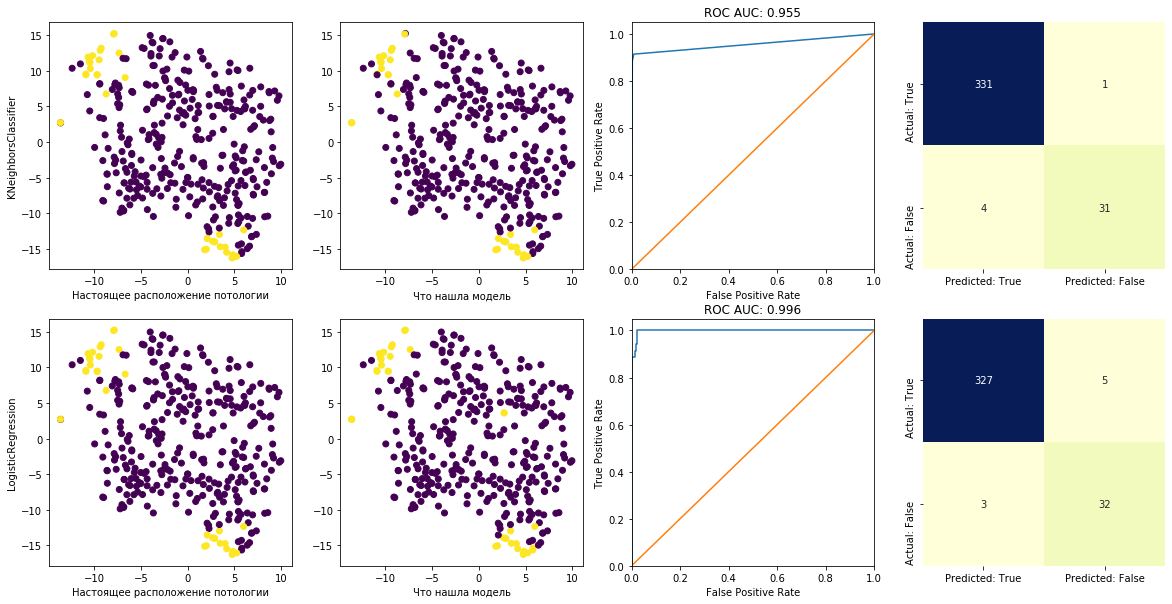

In [46]:
plt.figure(figsize=(20,10))

plt.subplot(2,4,1)
plt.scatter(tsne_test[:, 0], tsne_test[:, 1], c=y_test)
plt.xlabel('Настоящее расположение потологии')
plt.ylabel('KNeighborsClassifier')
plt.subplot(2,4,2)
plt.scatter(tsne_test[:, 0], tsne_test[:, 1], c=km_labels)
plt.xlabel('Что нашла модель')
plt.subplot(2,4,3)
sf.plot_roc_curve(km_proba, y_test)
plt.subplot(2,4,4)
sf.plot_confusion(y_test,km_labels)

plt.subplot(2,4,5)
plt.scatter(tsne_test[:, 0], tsne_test[:, 1], c=y_test)
plt.xlabel('Настоящее расположение потологии')
plt.ylabel('LogisticRegression')
plt.subplot(2,4,6)
plt.scatter(tsne_test[:, 0], tsne_test[:, 1], c=logreg_labels)
plt.xlabel('Что нашла модель')
plt.subplot(2,4,7)
sf.plot_roc_curve(logreg_proba, y_test)
plt.subplot(2,4,8)
sf.plot_confusion(y_test,logreg_labels)

Лучше задачей предсказания потологии сердца справилась модель KNeighborsClassifier пропустив меньше всего больных